In [3]:
import pandas as pd
import numpy as np
import logging
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.ticker as ticker
pd.options.display.max_rows = 999
logger = logging.getLogger()

import datetime as dt
import matplotlib.dates as mdates


In [4]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [3]:
r = pd.read_excel(' sheet_name = 'r')
ins1 = SimpleExpSmoothing(r['r']).fit(smoothing_level=0.05,optimized=False)
r['r_smoothed'] = ins1.fittedvalues

In [4]:
df_cases = pd.read_excel('./vax-immune.xlsx', sheet_name = 'cases')
df_vax   = pd.read_excel('./vax-immune.xlsx', sheet_name = 'vax')
recovered = pd.read_excel('./recovered.xlsx', sheet_name = 'rec')

In [76]:
recovered['sum'] = recovered['recovered'].cumsum()

In [77]:
df_vax['daily_gain'] = df_vax['vax2'].diff()
df_vax['daily_gain3'] = df_vax['vax3'].diff()
display(df_vax)

,date,vax1,vax2,vax3,daily_gain,daily_gain3
0,19-12-2020,61,0,0,NaN,NaN
1,20-12-2020,7440,0,0,0.0,0.0
2,21-12-2020,32328,0,0,0.0,0.0
3,22-12-2020,76953,0,0,0.0,0.0
4,23-12-2020,139804,0,0,0.0,0.0
5,24-12-2020,213161,0,0,0.0,0.0
6,25-12-2020,251629,0,0,0.0,0.0
7,26-12-2020,284213,0,0,0.0,0.0
8,27-12-2020,388641,0,0,0.0,0.0
9,28-12-2020,523516,0,0,0.0,0.0


In [78]:
def calc_average_day (df_vax, col_in):
    l = list()
    for i, row in df_vax.iterrows():
        if i < 9:
            l.append(np.NaN)
            continue
            
        until_now = df_vax[col_in][1:i-7]
        s = until_now.sum()
        
        until_now = until_now / s
        day_from_vax2 = np.arange(len(until_now), 0, -1)
        avg_day = np.dot(until_now, day_from_vax2)
        l.append(avg_day)

    
    return l


df_vax['avg_day2'] = calc_average_day(df_vax, 'daily_gain')
df_vax['avg_day3'] = calc_average_day(df_vax, 'daily_gain3')
df_vax.head(200)

,date,vax1,vax2,vax3,daily_gain,daily_gain3,avg_day2,avg_day3
0,19-12-2020,61,0,0,NaN,NaN,NaN,NaN
1,20-12-2020,7440,0,0,0.0,0.0,NaN,NaN
2,21-12-2020,32328,0,0,0.0,0.0,NaN,NaN
3,22-12-2020,76953,0,0,0.0,0.0,NaN,NaN
4,23-12-2020,139804,0,0,0.0,0.0,NaN,NaN
5,24-12-2020,213161,0,0,0.0,0.0,NaN,NaN
6,25-12-2020,251629,0,0,0.0,0.0,NaN,NaN
7,26-12-2020,284213,0,0,0.0,0.0,NaN,NaN
8,27-12-2020,388641,0,0,0.0,0.0,NaN,NaN
9,28-12-2020,523516,0,0,0.0,0.0,NaN,NaN


In [79]:
def crude_ve(df_cases):
    df_cases['ve_dose2'] = 1 - (df_cases['cases_vax2_norm'] / df_cases['cases_vax0_norm'])
    df_cases['ve_dose3'] = 1 - (df_cases['cases_vax3_norm'] / df_cases['cases_vax0_norm'])
    df_cases['ve_dose3_2'] = 1 - (df_cases['cases_vax3_norm'] / df_cases['cases_vax2_norm'])
    
    return df_cases

df_cases = crude_ve(df_cases)
display(df_cases)

,date,cases_vax3,cases_vax2,cases_vax0,cases_vax3_norm,cases_vax2_norm,cases_vax0_norm,ve_dose2,ve_dose3,ve_dose3_2
0,20-01-2021,0,17,7161,0.0,14.3,78.5,0.817834,1.000000,1.000000
1,21-01-2021,0,25,6261,0.0,13.3,69.3,0.808081,1.000000,1.000000
2,22-01-2021,0,26,6322,0.0,11.6,70.3,0.834993,1.000000,1.000000
3,23-01-2021,0,12,2012,0.0,4.8,22.5,0.786667,1.000000,1.000000
4,24-01-2021,0,29,4101,0.0,8.7,46.3,0.812095,1.000000,1.000000
5,25-01-2021,0,72,7405,0.0,15.8,84.9,0.813899,1.000000,1.000000
6,26-01-2021,0,95,6599,0.0,16.0,77.0,0.792208,1.000000,1.000000
7,27-01-2021,0,116,6442,0.0,15.8,76.5,0.793464,1.000000,1.000000
8,28-01-2021,0,173,5868,0.0,19.2,71.2,0.730337,1.000000,1.000000
9,29-01-2021,0,131,5557,0.0,13.5,68.1,0.801762,1.000000,1.000000


In [80]:
df_all = pd.merge(df_vax, df_cases, "inner", on='date')
df_all = pd.merge(df_all, r, "inner", on='date')
df_all = pd.merge(df_all, recovered, "inner", on='date')

df_all['date'] = pd.to_datetime(df_all['date'], format='%d-%m-%Y')
display(df_all)

,date,vax1,vax2,vax3,daily_gain,daily_gain3,avg_day2,avg_day3,cases_vax3,cases_vax2,...,cases_vax3_norm,cases_vax2_norm,cases_vax0_norm,ve_dose2,ve_dose3,ve_dose3_2,r,r_smoothed,recovered,sum
0,2021-01-20,2427756,734386,0,143532.0,0.0,1.514473,NaN,0,17,...,0.0,14.3,78.5,0.817834,1.000000,1.000000,0.95,1.071378,8819,484330
1,2021-01-21,2497476,898544,0,164158.0,0.0,1.783413,NaN,0,25,...,0.0,13.3,69.3,0.808081,1.000000,1.000000,0.97,1.065309,10049,494379
2,2021-01-22,2535211,969534,0,70990.0,0.0,2.125760,NaN,0,26,...,0.0,11.6,70.3,0.834993,1.000000,1.000000,0.99,1.060544,8519,502898
3,2021-01-23,2575079,1023040,0,53506.0,0.0,2.782700,NaN,0,12,...,0.0,4.8,22.5,0.786667,1.000000,1.000000,1.00,1.057017,4208,507106
4,2021-01-24,2644039,1163513,0,140473.0,0.0,3.491604,NaN,0,29,...,0.0,8.7,46.3,0.812095,1.000000,1.000000,1.00,1.054166,10614,517720
5,2021-01-25,2724792,1302800,0,139287.0,0.0,3.605294,NaN,0,72,...,0.0,15.8,84.9,0.813899,1.000000,1.000000,1.00,1.051457,5652,523372
6,2021-01-26,2803300,1428992,0,126192.0,0.0,3.648268,NaN,0,95,...,0.0,16.0,77.0,0.792208,1.000000,1.000000,1.00,1.048885,5114,528486
7,2021-01-27,2881019,1553817,0,124825.0,0.0,3.798382,NaN,0,116,...,0.0,15.8,76.5,0.793464,1.000000,1.000000,1.00,1.046440,8727,537213
8,2021-01-28,2960444,1684215,0,130398.0,0.0,4.056007,NaN,0,173,...,0.0,19.2,71.2,0.730337,1.000000,1.000000,0.99,1.044118,9288,546501
9,2021-01-29,2996979,1748880,0,64665.0,0.0,4.315002,NaN,0,131,...,0.0,13.5,68.1,0.801762,1.000000,1.000000,0.97,1.041412,7587,554088


"\n\naxs[1].plot(df_all['date'], df_all['avg_day2'])\naxs[1].xaxis.set_major_locator(ticker.MultipleLocator(14))\naxs[1].set_ylabel('Avg. time from a week after the second dose')\nfor tick in axs[1].get_xticklabels():\n    tick.set_rotation(90)\n\naxs[2].scatter(df_all['avg_day2'], smoothed)\n"

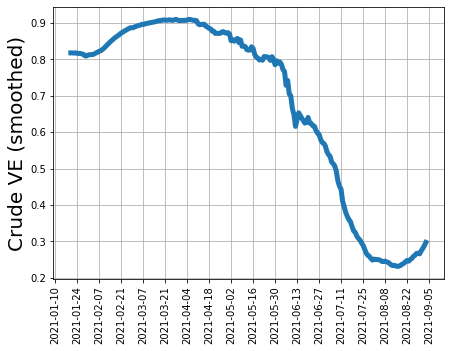

In [81]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (7,5))

data = df_all['ve_dose2']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed = ins1.fittedvalues
axs.plot(df_all['date'], smoothed, linewidth=5)
axs.xaxis.set_major_locator(ticker.MultipleLocator(14))
axs.set_ylabel(r'Crude VE (smoothed)', fontsize=20)


for tick in axs.get_xticklabels():
    tick.set_rotation(90)
    
axs.grid()
'''

axs[1].plot(df_all['date'], df_all['avg_day2'])
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(14))
axs[1].set_ylabel('Avg. time from a week after the second dose')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)

axs[2].scatter(df_all['avg_day2'], smoothed)
'''

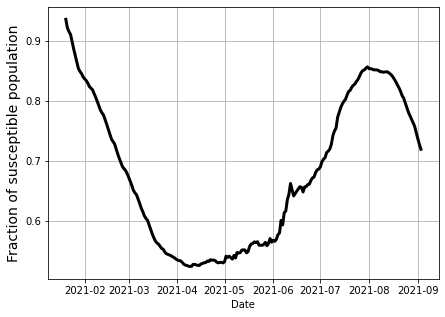

In [93]:
data = df_all['ve_dose3']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed_ve3 = ins1.fittedvalues

data = df_all['ve_dose2']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed_ve2 = ins1.fittedvalues

data = df_all['recovered']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed_recovered = ins1.fittedvalues

fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (7,5))
isr_protection = \
                1 - \
                 (smoothed_ve2 * (df_all['vax2'] - df_all['vax3']) + \
                 smoothed_ve3 * df_all['vax3']) / (9.4 * 10 ** 6)

ax1.plot(df_all['date'], isr_protection, color = 'black',  linewidth = 3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Fraction of susceptible population', color='black', fontsize = 14)
ax1.grid()

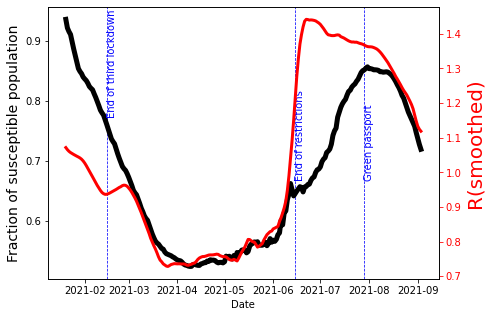

In [96]:
data = df_all['ve_dose3']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed_ve3 = ins1.fittedvalues

data = df_all['ve_dose2']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed_ve2 = ins1.fittedvalues

data = df_all['recovered']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed_recovered = ins1.fittedvalues

isr_protection = \
                1 - \
                 (smoothed_ve2 * (df_all['vax2'] - df_all['vax3']) + \
                 smoothed_ve3 * df_all['vax3']) / (9.4 * 10 ** 6)


fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (7,5))
ax2 = ax1.twinx()

ax1.plot(df_all['date'], isr_protection, color = 'black', linewidth = 5)
ax2.plot(df_all['date'], df_all['r_smoothed'], color = 'red', linewidth = 3)

ax1.set_xlabel('Date')
ax1.set_ylabel('Fraction of susceptible population', color='black', fontsize = 14)
ax2.set_ylabel('R(smoothed)', color='red', fontsize = 20)

y0, y1 = ax1.get_ylim()
x = dt.datetime(2021, 2, 15)
ax1.vlines(x, y0, y1, linestyle = 'dashed', color = 'blue', linewidth = 0.75)
ax1.set_ylim(y0,y1)
ax1.text(x, y1*0.81, 'End of third lockdown', color = 'blue', rotation = 'vertical')

y0, y1 = ax1.get_ylim()
x = dt.datetime(2021, 6, 15)
ax1.vlines(x, y0, y1, linestyle = 'dashed', color = 'blue', linewidth = 0.75)
ax1.set_ylim(y0,y1)
ax1.text(x, y1*0.7, 'End of restrictions', color = 'blue', rotation = 'vertical')


y0, y1 = ax1.get_ylim()
x = dt.datetime(2021, 7, 29)
ax1.vlines(x, y0, y1, linestyle = 'dashed', color = 'blue', linewidth = 0.75)
ax1.set_ylim(y0,y1)
ax1.text(x, y1*0.7, 'Green passport', color = 'blue', rotation = 'vertical')




#annotate('Test', (mdates.date2num(x), 0.7), xytext=(15, 15), 
#            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))



#ax1.grid()

[t.set_color('red') for t in ax2.yaxis.get_ticklines()]
[t.set_color('red') for t in ax2.yaxis.get_ticklabels()]





plt.show()












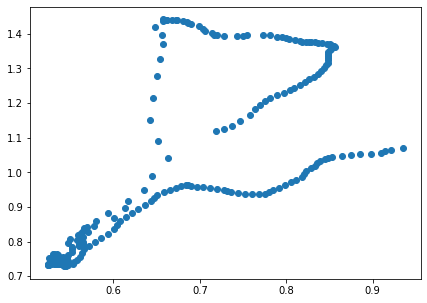

In [61]:
tmp = df_all[df_all.index > 39] #ugly code!
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (7,5))
ax1.scatter(isr_protection, df_all['r_smoothed'])
#ax1.set_xlabel('Date')
#ax1.set_ylabel('Fraction of susceptible population', color='black', fontsize = 14)
#ax1.grid()

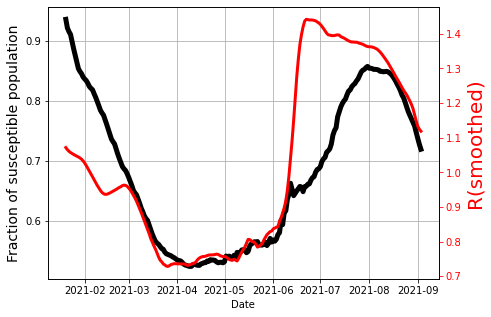

Text(3, 1.8, 'Local Max')

In [20]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (7,5))
ax2 = ax1.twinx()

ax1.plot(df_all['date'], isr_protection, color = 'black', linewidth = 5)
ax2.plot(df_all['date'], df_all['r_smoothed'], color = 'red', linewidth = 3)

ax1.set_xlabel('Date')
ax1.set_ylabel('Fraction of susceptible population', color='black', fontsize = 14)
ax2.set_ylabel('R(smoothed)', color='red', fontsize = 20)

ax1.grid()

[t.set_color('red') for t in ax2.yaxis.get_ticklines()]
[t.set_color('red') for t in ax2.yaxis.get_ticklabels()]
plt.show()



ax1.annotate('Local Max', xy =(3.3, 1),
                xytext =(3, 1.8), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)

<ipython-input-10-0ff9c0df8789>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['delta'][135:] = df_all['delta'][135:] * 0.8


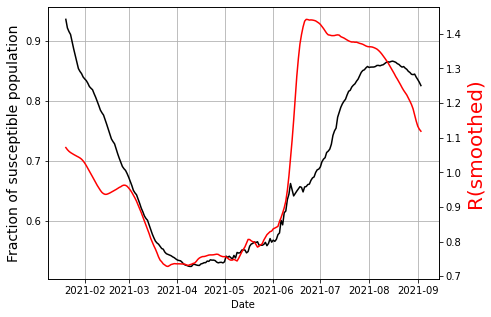

In [10]:
df_all['delta'] = np.ones(df_all.shape[0])
df_all['delta'][135:] = df_all['delta'][135:] * 0.8
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (7,5))
ax2 = ax1.twinx()

isr_protection = 1 - (smoothed * df_all['vax2'] / (9.4 * 10**6))

ax1.plot(df_all['date'], isr_protection, color = 'black')
ax2.plot(df_all['date'], df_all['r_smoothed'], color = 'red')

ax1.set_xlabel('Date')
ax1.set_ylabel('Fraction of susceptible population', color='black', fontsize = 14)
ax2.set_ylabel('R(smoothed)', color='red', fontsize = 20)

ax1.grid()
plt.show()


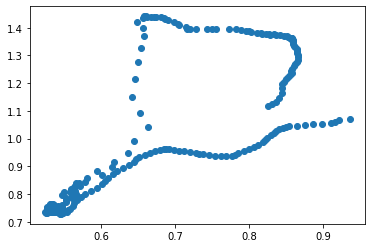

In [220]:
plt.scatter(isr_protection, df_all['r_smoothed'])

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


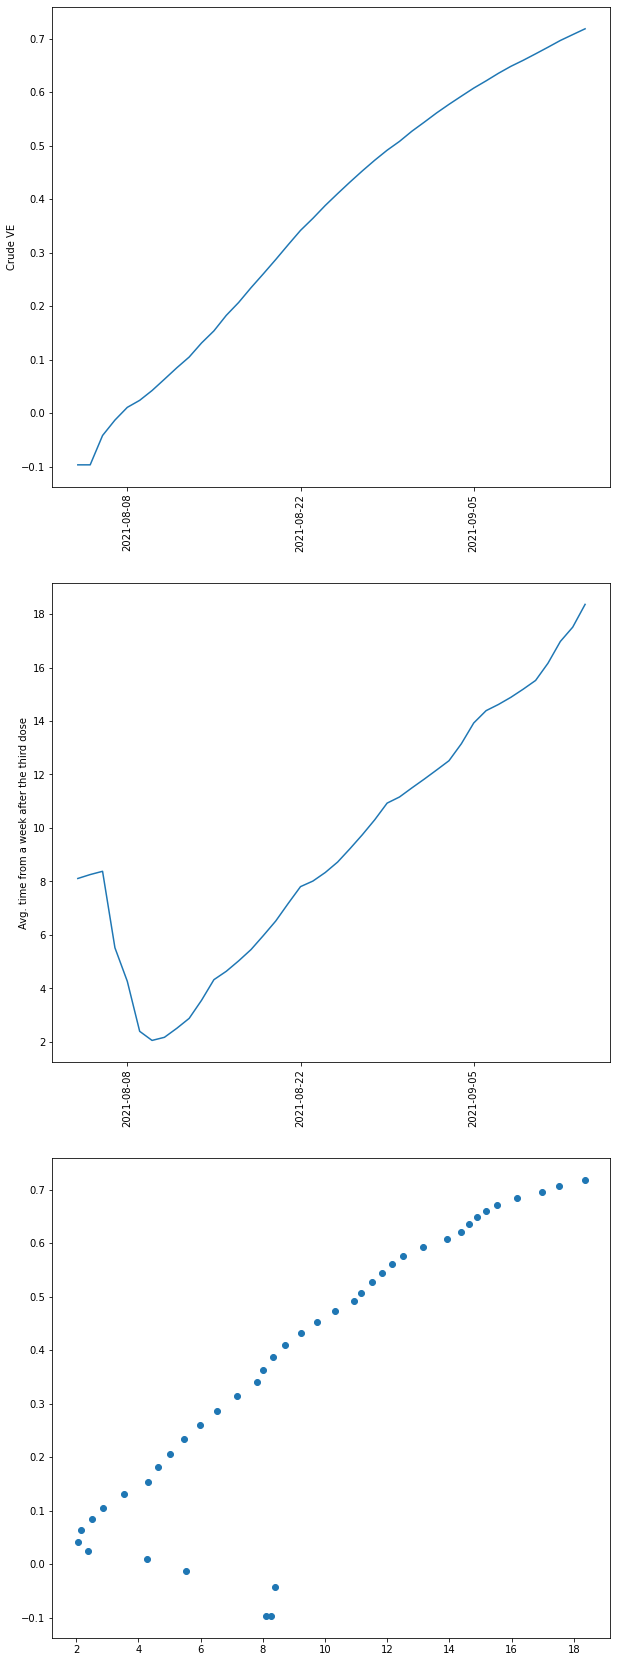

In [182]:
import datetime 

tmp = df_all[df_all.index > 195] #ugly code!
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (10,30))

data = tmp['ve_dose3']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed = ins1.fittedvalues
axs[0].plot(tmp['date'], smoothed)
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(14))
axs[0].set_ylabel('Crude VE')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)

'''
axs[1].plot(tmp['date'], tmp['avg_day3'])
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(14))
axs[1].set_ylabel('Avg. time from a week after the third dose')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)

axs[2].scatter(tmp['avg_day3'], smoothed)

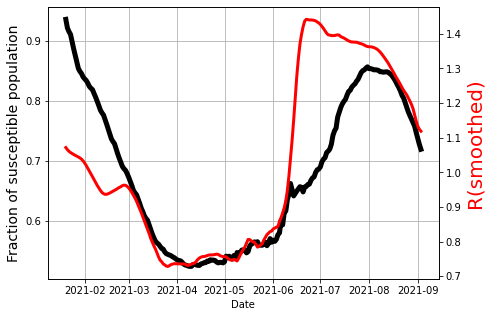

In [263]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (7,5))
ax2 = ax1.twinx()

data = df_all['ve_dose3']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed_ve3 = ins1.fittedvalues

data = df_all['ve_dose2']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed_ve2 = ins1.fittedvalues

avg_protection = 1 - (smoothed_ve2 * (df_all['vax2'] - df_all['vax3']) + smoothed_ve3 * df_all['vax3'])/(9.4 * 10 ** 6)
ax1.plot(df_all['date'], avg_protection, color = 'black', linewidth = 5)
ax2.plot(df_all['date'], df_all['r_smoothed'], color = 'red', linewidth = 3)




ax1.set_xlabel('Date')
ax1.set_ylabel('Fraction of susceptible population', color='black', fontsize = 14)
ax2.set_ylabel('R(smoothed)', color='red', fontsize = 20)

ax1.grid()
plt.show()


[t.set_color('red') for t in ax2.yaxis.get_ticklines()]
[t.set_color('red') for t in ax2.yaxis.get_ticklabels()]






plt.show()



/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


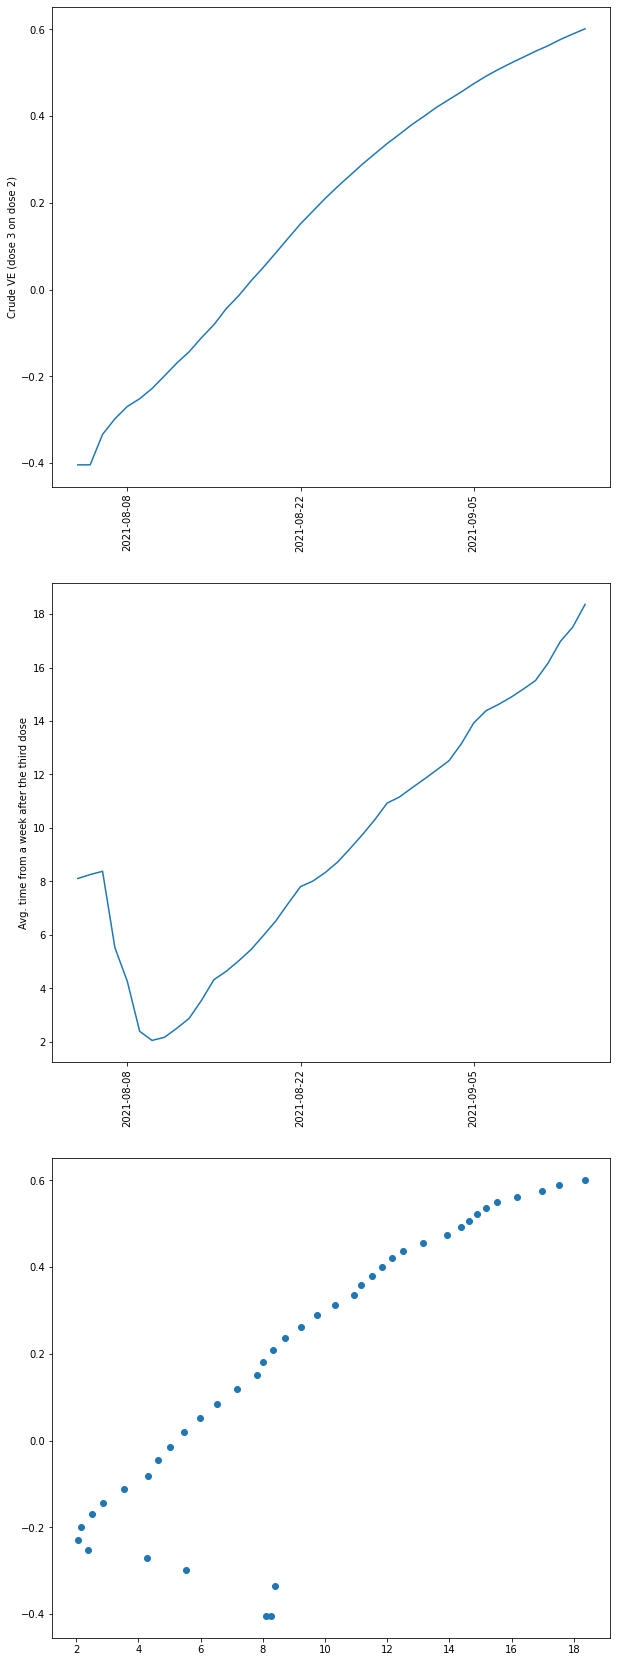

In [183]:
import datetime 

tmp = df_all[df_all.index > 195] #ugly code!
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (10,30))

data = tmp['ve_dose3_2']
ins1 = SimpleExpSmoothing(data).fit(smoothing_level=0.05,optimized=False)
smoothed = ins1.fittedvalues
axs[0].plot(tmp['date'], smoothed)
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(14))
axs[0].set_ylabel('Crude VE (dose 3 on dose 2)')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)


axs[1].plot(tmp['date'], tmp['avg_day3'])
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(14))
axs[1].set_ylabel('Avg. time from a week after the third dose')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)

axs[2].scatter(tmp['avg_day3'], smoothed)